# Data Gathering

### Loading Modules

In [1]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import warnings # Ignores any warning
warnings.filterwarnings("ignore")

### Loading Dataset

In [2]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

In [3]:
train['Item_Outlet_Sales'] = train['Item_Outlet_Sales'].round()

In [4]:
train['Item_Outlet_Sales']=train['Item_Outlet_Sales'].transform(func='sqrt')

In [5]:
data = pd.concat([train, test],ignore_index=True)

# Data Preprocessing

### Handling Missing Data 

In [6]:
#Checking count of null values
data.isnull().sum()

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
dtype: int64

Mode Imputation technique is applied for Categorical attrributes whereas Mean Imputation technique is applied for Numeric attributes

In [7]:
#Item_Weight 
print ('Orignal #missing: %d'%sum(data['Item_Weight'].isnull()))
data['Item_Weight'].fillna(value=data['Item_Weight'].mean(),inplace=True)
print ('Final #missing: %d'%sum(data['Item_Weight'].isnull()))

Orignal #missing: 2439
Final #missing: 0


In [8]:
data.groupby('Outlet_Identifier').Outlet_Size.value_counts(dropna=False)

Outlet_Identifier  Outlet_Size
OUT010             NaN             925
OUT013             High           1553
OUT017             NaN            1543
OUT018             Medium         1546
OUT019             Small           880
OUT027             Medium         1559
OUT035             Small          1550
OUT045             NaN            1548
OUT046             Small          1550
OUT049             Medium         1550
Name: Outlet_Size, dtype: int64

In [9]:
data.groupby('Outlet_Type').Outlet_Size.value_counts(dropna=False)

Outlet_Type        Outlet_Size
Grocery Store      NaN             925
                   Small           880
Supermarket Type1  Small          3100
                   NaN            3091
                   High           1553
                   Medium         1550
Supermarket Type2  Medium         1546
Supermarket Type3  Medium         1559
Name: Outlet_Size, dtype: int64

We see that only OUT010, OUT017, OUT045 HAS NA values and grocery store and supermarket Type 1 has only Small as the outlet size, so we can replace the nan with small

In [10]:
data.loc[data.Outlet_Identifier.isin(['OUT010','OUT017','OUT045']), 
         'Outlet_Size'] = 'Small'

In [11]:
data.Outlet_Size.value_counts()

Small     7996
Medium    4655
High      1553
Name: Outlet_Size, dtype: int64

### Handling Outliers 

Item Visibility has 0 in most cases, this is an outlier that can be replaced by the mean of Item visibility of each category of Item Identifier.

In [12]:
#Count of '0's 
count=0
for i in range(len(data)):
    if(data['Item_Visibility'][i]==0):
        count= count+1
print(count)

879


In [13]:
data.loc[data.Item_Visibility == 0, 'Item_Visibility'] = np.nan

#aggregate by Item_Identifier
IV_mean = data.groupby('Item_Identifier').Item_Visibility.mean()
IV_mean.head()

Item_Identifier
DRA12    0.044920
DRA24    0.045646
DRA59    0.148204
DRB01    0.091127
DRB13    0.007648
Name: Item_Visibility, dtype: float64

In [14]:
data.Item_Visibility.fillna(0, inplace=True)

for index, row in data.iterrows():
    if(row.Item_Visibility == 0):
        data.loc[index, 'Item_Visibility'] = IV_mean[row.Item_Identifier]
        
data.Item_Visibility.describe()
#See that min value is not zero anymore

count    14204.000000
mean         0.070458
std          0.050086
min          0.003575
25%          0.031381
50%          0.058064
75%          0.098042
max          0.328391
Name: Item_Visibility, dtype: float64

Creating a broad category of Type of Item into Food, Non-Consumable and Drinks

In [15]:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                    'NC':'Non-Consumable',
                                                    'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

Making data manipulation for Fat Content to 'Low Fat' and 'Regular'. Even there are items that are Non Consumable, so 'Non Edible' is also added.

In [16]:
#Change categories of low fat:
print ('Original Categories:')
print (data['Item_Fat_Content'].value_counts())

print ('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                    'reg':'Regular',
                                                    'low fat':'Low Fat'})
print (data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [17]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumable",
         'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [18]:
#data.head()

### Label Encoding

Label encoding of categorical variables are done after which One hot encoding is applied on these transformed variables.

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size',
           'Item_Type_Combined','Outlet_Type','Outlet']

le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [20]:
data = pd.get_dummies(data, columns=['Item_Fat_Content',
                'Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

# Feature Engineering

Remember the data is from 2013. So to take outlet's year in to account, it is subtracted from 2013

In [21]:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

Attributes such as Item Identifier, Outlet Identifier and Item Type are dropped from the data since new attributes have been created from these.

In [64]:
data.drop('Item_Identifier', axis=1,inplace=True)
data.drop('Outlet_Identifier', axis=1,inplace=True)
data.drop('Outlet_Establishment_Year', axis=1,inplace=True)
data.drop('Item_Type', axis=1,inplace=True)

In [23]:
#data.head()

# Model Building

### Pre Model Building Tasks

Training and testing sets will be created with 75%-25% ratio split. 

In [65]:
old = data[:8522]
fut = data[8523:]

In [66]:
column = data.columns
x = old[column]
x.drop('Item_Outlet_Sales', axis=1,inplace=True)
y = old['Item_Outlet_Sales']
#df(y.head())

In [67]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                test_size=0.25, random_state=42)

In [68]:
x_train.head()

,Item_MRP,Item_Visibility,Item_Weight,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Size_0,...,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9,Outlet_Years
6864,214.7192,0.030155,14.000000,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,11
7006,262.1278,0.048738,9.895000,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,14
5325,222.0114,0.030144,12.792854,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,28
2867,178.5318,0.044230,12.792854,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,28
4376,97.2726,0.063851,6.905000,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,15


Before choosing a particular machine learning algorithm it is trained using different algorithms like Linear Regression, Lasso Regression, Decision Tree Regression and Random Forest Regression.

### Linear Regression 

In [28]:
from sklearn.linear_model import LinearRegression, Ridge

In [69]:
#Training the model
lr = LinearRegression(normalize=True)
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [70]:
# Predict training set
y_pred = lr.predict(x_test)

#Evaluating the model
from sklearn.metrics import mean_absolute_error, r2_score
print('MSE : ',mean_absolute_error(y_test, y_pred))
print('R2 : ',r2_score(y_test, y_pred))

MSE :  8.4075893888102
R2 :  0.6511557041155609


Mean Square Error is 8.41 for Linear Regression and Co-efficient of determination is 56.2%

### Ridge Regression

In [71]:
rr = Ridge(alpha=0.05, normalize=True, random_state=42)
rr.fit(x_train, y_train)

Ridge(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=42, solver='auto', tol=0.001)

In [72]:
y_pred_r = rr.predict(x_test)
print('MSE : ',mean_absolute_error(y_test, y_pred_r))
print('R2 : ',r2_score(y_test, y_pred_r))

MSE :  8.409414902224167
R2 :  0.6508901197785909


### Decision Tree

In [73]:
from sklearn.tree import DecisionTreeRegressor

In [74]:
dr = DecisionTreeRegressor(random_state=42, 
                           max_depth=5, min_samples_leaf=73)
dr.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=73,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [75]:
y_pred_d = dr.predict(x_test)
print('MSE : ',mean_absolute_error(y_test, y_pred_d))
print('R2 : ',r2_score(y_test, y_pred_d))

MSE :  8.059676368516598
R2 :  0.6658133687519506


### Random Forest

In [76]:
from sklearn.ensemble import RandomForestRegressor

In [77]:
rf = RandomForestRegressor(n_estimators=8, 
                           max_depth=5, random_state=42)
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=None,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [78]:
y_pred_f = rf.predict(x_test)
print('MSE : ',mean_absolute_error(y_test, y_pred_f))
print('R2 : ',r2_score(y_test, y_pred_f))

MSE :  7.991802463661631
R2 :  0.6693445547857142


Random Forest Regression performs better than others with R2 score of 66.9%. Parameter Tuning is done to check if any improvement cwn be done in the score.

In [79]:
numeric_features = data.select_dtypes(include=[np.number])
corr =numeric_features.corr()
cor = corr['Item_Outlet_Sales'].sort_values(ascending=False)
print(cor[cor>0.20])
print(cor[cor<-0.20])

Item_Outlet_Sales    1.000000
Item_MRP             0.563424
Outlet_5             0.291096
Outlet_Type_3        0.291096
Outlet_Size_1        0.219784
Name: Item_Outlet_Sales, dtype: float64
Outlet_Size_2   -0.234703
Outlet_4        -0.359002
Outlet_0        -0.370612
Outlet_Type_0   -0.534412
Name: Item_Outlet_Sales, dtype: float64


In [40]:
from sklearn.feature_selection import RFE

In [80]:
rfe = RFE(rf, 10)
fit = rfe.fit(x_train, y_train)

In [81]:
col = x_train.columns
features = df(fit.ranking_,col)

In [82]:
d_range = range(5, 10)
dscores = []

for k in d_range:
    new = features[features[0]<k]
    x_tr = x_train[new.index]
    x_tt = x_test[new.index]
    dt = RandomForestRegressor(n_estimators=8, max_depth=5,
                            random_state=42)
    dt.fit(x_tr, y_train)
    y_pred = dt.predict(x_tt)
    dscores.append(r2_score(y_test, y_pred))
print(np.array(dscores).max())

0.6693623241957185


Text(0, 0.5, 'R2 Score')

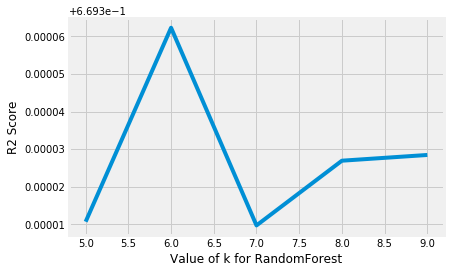

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(d_range, dscores)
plt.xlabel('Value of k for RandomForest')
plt.ylabel('R2 Score')

In [85]:
new = features[features[0]<6]
new.index
x_tr = x_train[new.index]
x_tt = x_test[new.index]
x_tr.head()

,Item_MRP,Item_Visibility,Item_Weight,Item_Fat_Content_0,Item_Fat_Content_2,Outlet_Location_Type_0,Outlet_Type_0,Outlet_Type_3,Item_Type_Combined_0,Item_Type_Combined_1,Item_Type_Combined_2,Outlet_2,Outlet_5,Outlet_Years
6864,214.7192,0.030155,14.000000,1,0,0,0,0,0,1,0,0,0,11
7006,262.1278,0.048738,9.895000,0,1,1,0,0,0,1,0,0,0,14
5325,222.0114,0.030144,12.792854,0,1,0,0,1,0,1,0,0,1,28
2867,178.5318,0.044230,12.792854,0,1,1,1,0,0,1,0,0,0,28
4376,97.2726,0.063851,6.905000,0,1,0,1,0,0,1,0,0,0,15


In [86]:
rf = RandomForestRegressor(n_estimators=26, max_depth=5,
                            random_state=42)
rf.fit(x_tr, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=26,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [87]:
y_pred_f = rf.predict(x_tt)
print('MSE : ',mean_absolute_error(y_test, y_pred_f))
print('R2 : ',r2_score(y_test, y_pred_f))

MSE :  7.96415536721046
R2 :  0.672023732242052


In [88]:
y_actual = (y_test)**2
y_est = (y_pred_f)**2
df({'Predicted':y_est.round(),'Actual':y_actual}).head(10)

,Predicted,Actual
7501,194.0,99.0
7482,1745.0,3467.0
2572,2900.0,4248.0
1084,4714.0,5778.0
856,2925.0,2357.0
4325,1260.0,1480.0
2131,241.0,116.0
1385,1990.0,2411.0
3422,2005.0,1844.0
7256,3455.0,8324.0


### Parameter Tuning

In [89]:
d_range = range(10, 30)
dscores = []

for k in d_range:
    dt = RandomForestRegressor(n_estimators=k, max_depth=5, random_state=42)
    dt.fit(x_tr, y_train)
    y_pred = dt.predict(x_tt)
    dscores.append(r2_score(y_test, y_pred))
print(np.array(dscores).max())

0.672023732242052


Text(0, 0.5, 'R2 Score')

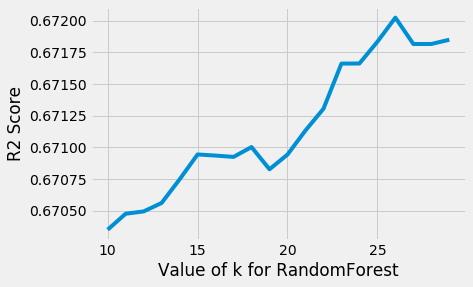

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.plot(d_range, dscores)
plt.xlabel('Value of k for RandomForest')
plt.ylabel('R2 Score')

There's an improvement in the R2 score of 1.3%. 

### Prediction for new data
The Random Forest Regression is used with the optimal parameters to predict Output Sales for new data.

In [98]:
fut = fut[new.index]
#fut.drop('Item_Outlet_Sales', axis=1, inplace=True)
fut.head()

,Item_MRP,Item_Visibility,Item_Weight,Item_Fat_Content_0,Item_Fat_Content_2,Outlet_Location_Type_0,Outlet_Type_0,Outlet_Type_3,Item_Type_Combined_0,Item_Type_Combined_1,Item_Type_Combined_2,Outlet_2,Outlet_5,Outlet_Years
8523,107.8622,0.007565,20.750000,1,0,1,0,0,0,1,0,0,0,14
8524,87.3198,0.038428,8.300000,0,1,0,0,0,0,1,0,1,0,6
8525,241.7538,0.099575,14.600000,0,0,0,1,0,0,0,1,0,0,15
8526,155.0340,0.015388,7.315000,1,0,0,0,0,0,1,0,1,0,6
8527,234.2300,0.118599,12.792854,0,1,0,0,1,0,1,0,0,1,28


In [100]:
rf = RandomForestRegressor(n_estimators=26, 
                           max_depth=5, random_state=42)
rf.fit(x_tr, y_train)
fut['Item_Outlet_Sales'] = ((rf.predict(fut))**2)

In [101]:
fut['Item_Outlet_Sales'].round().head()

8523    1550.0
8524    1341.0
8525     603.0
8526    2374.0
8527    5897.0
Name: Item_Outlet_Sales, dtype: float64